
$\bullet$ Cost function: $F(P) = D^T P^T T P$, where $P$ is a permutation matrix with elements in $\{0,1\}$,

and $D$ the distance matrix between cities and $T$ the cyclic graph. $P$ is a permutation.
Cost is sum over a cycle with edges ordered according to a certain route.

$\bullet$ The cost function can be rewritten as follows considering $X = aP-b$ (i.e., $P=\frac{X+b}{a}$) with elements in $\{a-b,a\}$:

$F(X) = (D^T X^T T X + b D^T X^T T + b D^T T X + b^2 D^T T)/a^2$.

$\bullet$ Euclidian gradient $\nabla F(P) = 2TPD$,

and Euclidian gradient $\nabla F(X) = 2 TXD/a^2 + 2b TD/a^2$,

$\bullet$ $P$ is orthonormal ($P^T P = I$).

$X$ is such that $X^T X = a^I + b(bN-2a)J$. 

When $a=1$ and $b = \frac{2}{N}$, $X^T X = I$ and X is orthonormal.

$\bullet$ Riemannian gradient on orthogonal matrices manifold

$\nabla_M F(X) = \nabla F(X) - X \text{sym} (X^T \nabla F(X) )$,

with $\text{sym}(A) = \frac{1}{2} (A + A^T)$.

$\bullet$ Can rewrite $\nabla_M F(X)$ as

$\nabla_M F(X) = \nabla F(X) - X \nabla F(X)^T X$ (numerically unstable),

$\nabla_M F(X) = X \{X,\nabla F(X)\}$, with $\{A,B\} = A^T B - B^T A$ (numerically stable).

$\bullet$ Dynamics without error correction: $\frac{d X}{dt} = -\nabla_M F(X) = - P \{P,\nabla F(X)\}$.

$\bullet$ Dynamics with error correction: 

$\frac{d X}{dt} = - X \{X, e \circ \nabla F(X) + \nabla V(X)\},$ with $V(X)$ the quadratic potential

$\frac{d e}{dt} = - \xi (Y^2 - 1) e$, with $Y = 2P-1 = 2 \frac{X+b}{a} - 1$.

Should converge to an orthogonal matrix with -1/1 elements only, i.e., Hadamard matrix.

$\bullet$ Steady-state: 

$\frac{d e}{dt} = 0$ $\implies$ $X = \pm \frac{1}{\sqrt{n}} = 0$

$\frac{d X}{dt} = 0$ $\implies$ $X \{X, e \circ \nabla F(X)\} = 0$

$\implies$ $X^T (e \circ \nabla F(X)) = (e \circ \nabla F(X))^T X $

(in case of CAC, we had $e \circ \nabla F(X) + \nabla V(X) = 0$)




In [1]:
using IJulia
using Manopt, Manifolds, Random, LinearAlgebra, ManifoldDiff
using ManifoldDiff: grad_distance, prox_distance
using DifferentialEquations
using Plots, DataFrames

In [2]:

N = 4

#for mapping
b = 2/N;
    

In [3]:
if false
        
    using DelimitedFiles
    
    function read_matrix(filename::String)
        """
        Reads a distance matrix from a file into a Julia array.
        
        Args:
            filename (String): The path to the file containing the distance matrix.
            
        Returns:
            Array{Int64, 2}: The distance matrix as a Julia array.
        """
        return readdlm(filename, ' ', Int)
    end
    
    # Example usage
    D = read_matrix("TSPs/test.tsp");
    D = D[1:N,1:N];
    #println("Read matrix from file:")
    #D
end

In [4]:
using Random

function generate_tsp_distance_matrix(num_cities::Int, symmetric::Bool=true)
    """
    Generates a distance matrix for the TSP.
    
    Args:
        num_cities (Int): Number of cities (nodes).
        symmetric (Bool): If true, generates a symmetric matrix. If false, generates a non-symmetric matrix.
        
    Returns:
        Array{Int, 2}: Distance matrix.
    """
    # Generate a random distance matrix
    distance_matrix = rand(1:99, num_cities, num_cities)

    if symmetric
        # Make the matrix symmetric
        for i in 2:num_cities, j in 1:i-1
            distance_matrix[i, j] = distance_matrix[j, i]
        end
    end
    
    # Set the diagonal to zero (no self-loops)
    for i in 1:num_cities
        distance_matrix[i, i] = 0
    end

    return distance_matrix
end

D = generate_tsp_distance_matrix(N, true)


4×4 Matrix{Int64}:
  0  71  93  42
 71   0  44  98
 93  44   0  74
 42  98  74   0

In [5]:
function cycle_graph_adjacency_matrix(n::Int, directed::Bool=true)
    """
    Generates the adjacency matrix of a cycle graph of length n.

    Args:
        n (Int): The number of nodes in the cycle graph.
        directed (Bool): If true, generates a directed cycle graph.
                         If false, generates an undirected cycle graph.

    Returns:
        Array{Int64, 2}: The adjacency matrix of the cycle graph.
    """
    # Initialize an n x n matrix with zeros
    adj_matrix = zeros(Int, n, n)
    
    if directed
        # Directed cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
        end
        adj_matrix[n, 1] = 1  # Last node connects to the first node
    else
        # Undirected cycle graph
        for i in 1:(n-1)
            adj_matrix[i, i+1] = 1
            adj_matrix[i+1, i] = 1
        end
        adj_matrix[n, 1] = 1
        adj_matrix[1, n] = 1  # Last node connects to the first node and vice versa
    end
    
    return adj_matrix
end

directed = false  # Set to false for undirected
T = cycle_graph_adjacency_matrix(N, directed);
#println("Adjacency matrix for cycle graph of length $n (directed=$directed):")
#T


# Dynamics


In [6]:

M₀ = UnitaryMatrices(N, ℝ)


OrthogonalMatrices(4)

In [22]:
function cost_fnc_P(P)
    return tr(transpose(D)*transpose(P)*T*P)
end
    
function cost_fnc_X(X)
    P = (sign.(2.0 .* (X .+ b) .- 1) .+ 1)/2 #but is not necessarily a permutation matrix
    return tr(transpose(D)*transpose(P)*T*P)
end

cost_fnc_X (generic function with 1 method)

In [24]:
#find ground-state by brute force

using Combinatorics  # Import Combinatorics for generating permutations
using LinearAlgebra  # Import LinearAlgebra for identity matrix

function generate_permutation_matrices(n)
    perms = collect(permutations(1:n))  # Generate all permutations of 1:n
    matrices = []

    for p in perms
        perm_matrix = I(n)[p, :]  # Generate permutation matrix from permutation
        push!(matrices, perm_matrix)  # Store the matrix
    end

    return matrices
end

# Example usage:
perm_matrices = generate_permutation_matrices(N)

H = []

for (i, mat) in enumerate(perm_matrices)

    cH = cost_fnc_P(Float64.(mat))
        
    if false
        println("Permutation Matrix $i:")
        println(mat)
        println(cH)
        print()
        println()
    end
    push!(H, cH)
end

H = Float64.(H)
H0 = minimum(H)
println("Optimal cost $H0")


Optimal cost 462.0


In [9]:
# compute the gradient for -1, +1 variables instead of 0,1

function permutation_matrix(N::Int)
    p = randperm(N)  # Generate a random permutation of integers 1 to N
    P = zeros(Int, N, N)  # Initialize an NxN matrix with zeros
    for i in 1:N
        P[i, p[i]] = 1  # Place a 1 in each row at the column indicated by the permutation
    end
    return P
end

if false
    # Example usage:
    P = permutation_matrix(N)
    println(tr(transpose(D)*transpose(P)*T*P))
    S = 2*P.-1
    O = ones(N,N);
    println(tr(transpose(D)*transpose((S.+1)/2)*T*(S.+1)/2))
    println(tr(transpose(D)*transpose(S.+1)*T*(S.+1))/4)
    println(tr(transpose(D)*transpose(S)*T*S + transpose(D)*transpose(S)*T*O + transpose(D)*O*T*S + transpose(D)*O*T*O)/4)
    println(tr(transpose(D)*transpose(S)*T*S)/4 + tr(transpose(D)*transpose(S)*T*O)/4 + tr(transpose(D)*O*T*S)/4 + tr(transpose(D)*O*T*O)/4)
    println(tr(transpose(D)*transpose(S)*T*S)/4 + tr(transpose(D)*transpose(S)*T*O)/4 + tr(transpose(D)*O*T*S)/4 + tr(transpose(D)*O*T*O)/4)
end


In [10]:

# Right hand side of the dif
function basic_rule3!(du, u, params, t)
    D = params[1]
    T = params[2]
    N = size(D, 1)  # Dimension of the matrix

    a = 1.0
    
    # Reshape the vector u to get the matrix P
    x = u[1:N^2]
    e = u[(N^2+1):(2*N^2)]
    f = u[(2*N^2+1):end]
    X = reshape(x, N, N)  #orthogonal -b, 1-b
    E = reshape(e, N, N)
    F = repeat(f, 1, N)  # Repeat along the rows

    P = X .+ b # 0,1 variable
    Y = 2.0 .* P .- 1 # -1, 1 variable
    
    # Euclidian gradient (descent)
    #grad = 2.0 .* T * X * D + (2*b) .* T * D
    grad = 2.0 .* T * X * D + (2*b) .* T * D .* F
    #dx_dt = E.* grad + 1.0*X .- X.^3
    dx_dt = - E.* grad
    #dx_dt = - E.* grad .+ F'
    
    # Riemannian gradient
    # (1)
    #A = X' * dx_dt
    #S = 0.5*(A + A')
    #dx_dt_M = 2*(dx_dt - X * S)

    # (2)
    #dx_dt_M = dx_dt - X * dx_dt' * X

    # (3)
    dx_dt_M = X * (X' * dx_dt - dx_dt' * X)

    de_dt = - 0.1 .* (Y.^2 .- a) .* E
    df_dt = 1 .* (sum(P,dims=2) .-1)
    #df_dt = f .* 0

    du[1:N^2] = vec(dx_dt_M)  # Flatten the matrix into a vector
    du[(N^2+1):(2*N^2)] = vec(de_dt)
    du[(2*N^2+1):end] = df_dt
    #du[(N^2+1):end] = de_dt

end

# define problem and run simulation
#e = rand(n,n)
e = ones(N,N)
f = ones(N)
#e = ones(n)
params = (D, T)     # (p, a, b, N, J)
params2 = (D, T, e)     # (p, a, b, N, J)
tspan = (0.0,100)

# initial condition(s)
P0 = rand(M₀) # This is P(t=0)
u0 = [vec(P0);vec(e);f]

#permutation = randperm(N)
#P0 = I(N)[permutation, :]
#X0 = P0 .- b
#u0 = [vec(X0);vec(e);f]

#p, beta, alpha, N J
#prob = ODEProblem(basic_rule!, u0, tspan, params)
#prob = ODEProblem(basic_rule2!, u0, tspan, params2)
prob = ODEProblem(basic_rule3!, u0, tspan, params)
#sol = solve(prob, Tsit5());
sol = solve(prob, Vern9(), reltol=1e-9, abstol=1e-12);

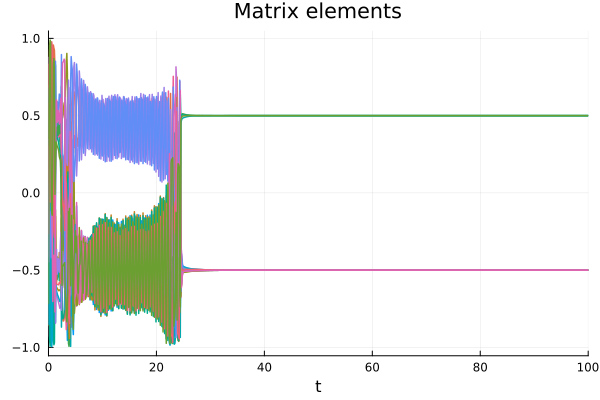

In [11]:
plot(sol, idxs=1:N^2, plotdensity=1000, lw=1.5, title="Matrix elements", legend=false)


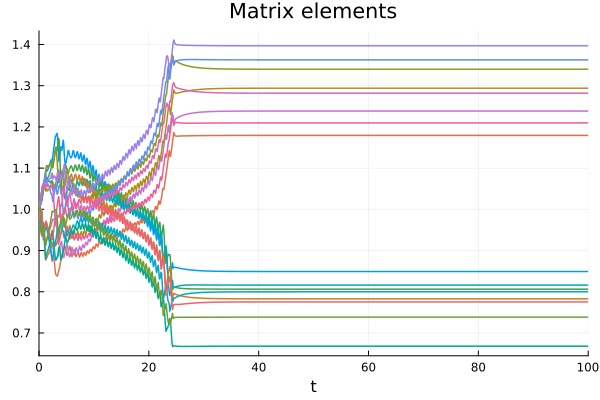

In [12]:
plot(sol, idxs=(N^2+1):(2*N^2), plotdensity=1000, lw=1.5, title="Matrix elements", legend=false)
#plot(sol, idxs=101:110, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)

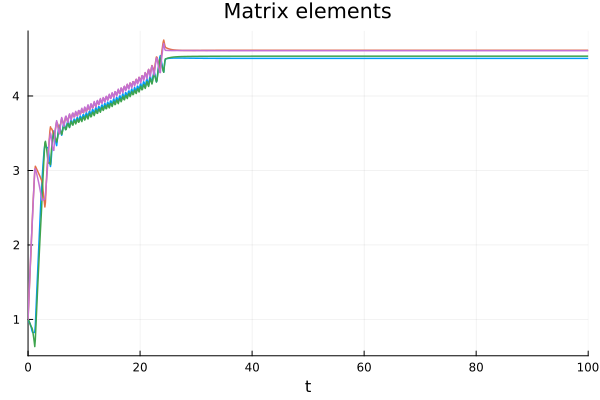

In [13]:
plot(sol, idxs=(2*N^2+1):(2*N^2+N), plotdensity=1000, lw=1.5, title="Matrix elements", legend=false)
#plot(sol, idxs=101:110, plotdensity=100, lw=1.5, title="Matrix elements", legend=false)

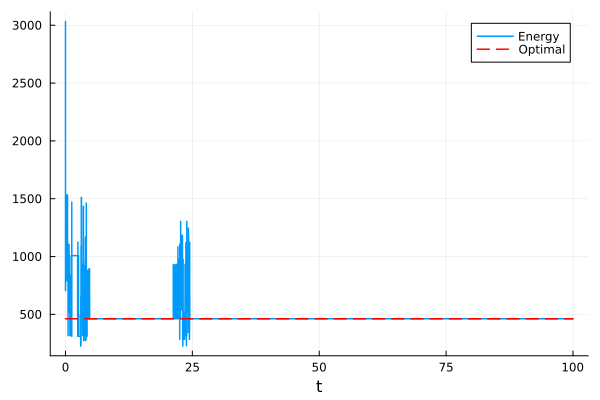

In [25]:
plot(sol.t,[ cost_fnc_X(reshape(x_t[1:N^2], N, N)) for x_t in sol.u] , label="Energy", lw=1.5, xlabel="t")
plot!(sol.t,fill(H0, length(sol.t)), label="Optimal", lw=1.5, xlabel="t",color=:red, linestyle=:dash)

In [15]:
X = sol.u[end]
X = reshape(X[1:N^2], N, N)
#P = (sign.(2.0 .* (X0 .+ b) .- 1) .+ 1)/2
#P = (sign.(2.0 .* (X .+ b) .- 1) .+ 1)/2
P = ((2.0 .* (X .+ b) .- 1) .+ 1)/2

X' * X


4×4 Matrix{Float64}:
  1.0          -7.52787e-13  -2.09177e-12   4.27713e-12
 -7.52787e-13   1.0          -4.30095e-12  -7.28811e-12
 -2.09177e-12  -4.30095e-12   1.0          -1.39045e-11
  4.27713e-12  -7.28811e-12  -1.39045e-11   1.0

In [16]:
P

4×4 Matrix{Float64}:
 -3.31768e-12  -1.26232e-13   1.0          -2.37554e-12
 -4.84179e-12   1.0           8.96061e-13  -6.52034e-13
  1.0          -2.30804e-12  -6.26055e-13   2.58504e-12
 -6.10734e-13  -2.01617e-12  -2.364e-12     1.0

In [17]:
sum(P,dims=1)

1×4 Matrix{Float64}:
 1.0  1.0  1.0  1.0

In [18]:
sum(P,dims=2)

4×1 Matrix{Float64}:
 1.0000000000058904
 1.0000000000003784
 0.9999999999951014
 1.0000000000041658

In [19]:
if false
    
    using LinearAlgebra

    # Example usage:
    n = 4  # Use 'n' instead of 'size' to avoid conflicts
    permutation = [3, 1, 4, 2]  # Julia uses 1-based indexing
    
    # Create the permutation matrix
    P = I(n)[permutation, :]
    
    Q = 2 .*P .- 1
    
    X = Q./sqrt(n)
    
    X' * X
    
end
